In [ ]:
#imports
import numpy as np; import pandas as pd; import random; from scipy.spatial.distance import cdist; import matplotlib.pyplot as plt;


In [ ]:
#task 1
data = pd.read_csv('team_game_data.csv')
data.head()

In [1]:

data = pd.read_csv('../Iris/iris.csv')
labels = data['label']
data = data[['sepal_length','sepal_width','petal_length','petal_width']].to_numpy()

In [1]:
#get centroids 
def get_initial_centroids(X, k):
    n_samples = X.shape[0]
    ids = random.sample(range(0, n_samples), k)

    centroids = [tuple(X[id]) for id in ids]
    unique_centroids = list(set(centroids))

    n_unique_centroids = len(unique_centroids)

    while n_unique_centroids < k:
        new_ids = random.sample(range(0, n_samples), k - n_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))

        n_unique_centroids = len(unique_centroids)

    return np.array(unique_centroids)

#euclidean,cosine,jaccard
def get_distance(A_matrix, B_matrix, function):
    return cdist(A_matrix, B_matrix, function)

def get_clusters(X, centroids, distance_function):
    k = centroids.shape[0]
    clusters = {}
    distance_matrix = get_distance(X, centroids, distance_function)
    print(distance_matrix)
    closest_cluster_ids = np.argmin(distance_matrix, axis=1)
    for i in range(k):
        clusters[i] = []
    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])
    return clusters

def has_centroids_covered(previous_centroids, new_centroids, distance_function, movement_threshold_delta):
    distance = get_distance(previous_centroids, new_centroids, distance_function)
    centroids_covered = np.max(distance.diagonal()) <= movement_threshold_delta

    return centroids_covered

def K_Means(X, k, distance_function, movement_threshold_delta=0):
    new_centroids = get_initial_centroids(X=X, k=k)

    centroids_covered = False

    while not centroids_covered:
        previous_centroids = new_centroids
        clusters = get_clusters(X, previous_centroids, distance_function)

        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(previous_centroids, new_centroids, distance_function, movement_threshold_delta)

    return new_centroids

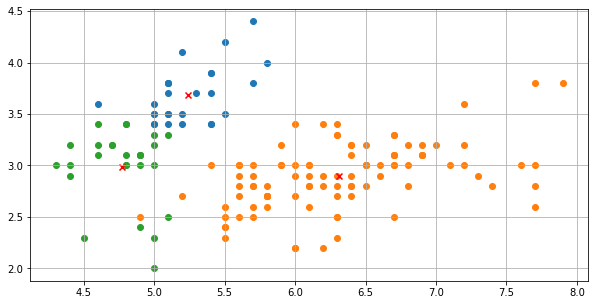

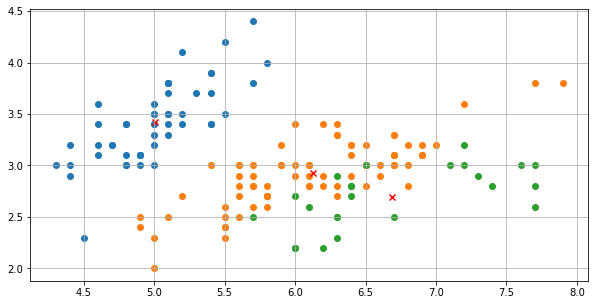

In [3]:
k = 3
for n in ['euclidean','cosine']:
    centroids = K_Means(data, k, n, movement_threshold_delta=1/10)
    clusters = get_clusters(data, centroids, n)

    plt.rcParams['figure.figsize'] = [10, 5]
    for centroid, points in clusters.items():
        points = np.array(points)
        centroid = np.mean(points, axis=0)


        plt.scatter(points[:, 0], points[:, 1], marker='o')
        plt.grid()
        plt.scatter(centroid[0], centroid[1], marker='x', color="red")

    plt.show()